In [1]:
from tensorflow import keras
from PIL import Image
import cv2
import tensorflow as tf
import numpy as np
import torch
import matplotlib.pyplot as plt
import os

### Resize and Save Image array

In [9]:
dir = './X4 Urban100/X4/HIGH x4 URban100/'

In [10]:
X = []
y = []

In [11]:
for d in list(os.walk(dir))[0][2]:

    img = np.array(Image.open(f"{dir}{d}"))[0:560, 0:560]
    noise = np.random.normal(0,15,img.shape)
    
    y.append(img/255)
    X.append((img+noise)/255)

In [12]:
X = np.array(X)
y = np.array(y)

In [13]:
X.shape, y.shape

((100, 560, 560, 3), (100, 560, 560, 3))

In [14]:
np.save('./X_resize',X)
np.save('./y_resize',y)

### Image Patching

In [15]:
X_patches = []
y_patches = []

In [16]:
X_resize = np.load('./X_resize.npy')[:80]
y_resize = np.load("./y_resize.npy")[:80]

In [17]:
for image in X_resize:
    extracted_patches = tf.image.extract_patches(images=tf.expand_dims(image ,0),sizes=[1,112,112,1],strides=[1,112,112,1],padding='SAME',rates=[1,1,1,1])
    X_patches.extend(list(tf.reshape(extracted_patches,[-1,112,112,3])))

In [18]:
for image in y_resize:
    extracted_patches = tf.image.extract_patches(images=tf.expand_dims(image ,0),sizes=[1,112,112,1],strides=[1,112,112,1],padding='SAME',rates=[1,1,1,1])
    y_patches.extend(list(tf.reshape(extracted_patches,[-1,112,112,3])))

In [19]:
X_patches = np.array(X_patches)
y_patches = np.array(y_patches)

In [20]:
X_patches.shape, y_patches.shape

((2000, 112, 112, 3), (2000, 112, 112, 3))

In [18]:
np.save('./X_patches',X_patches)
np.save('./y_patches',y_patches)

### Train and Save Model

In [2]:
X_patches = np.load('./X_patches.npy')
y_patches = np.load("./y_patches.npy")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


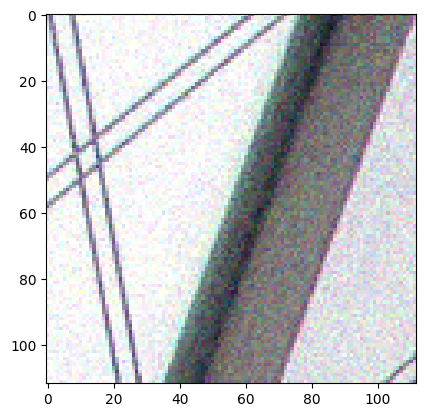

In [3]:
plt.imshow(X_patches[30])

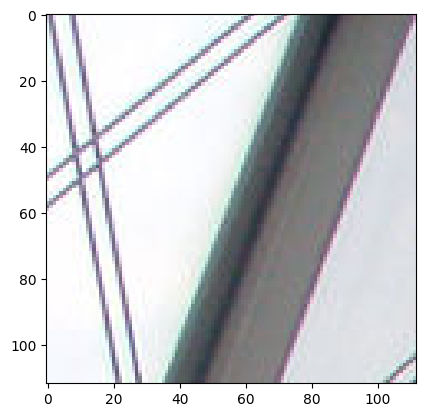

In [4]:
plt.imshow(y_patches[30])

In [5]:
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [6]:
def pixel_mse_loss(y_true,y_pred):
  return tf.reduce_mean( (y_true - y_pred) ** 2 )

def PSNR(y_true,y_pred):
  mse=tf.reduce_mean( (y_true - y_pred) ** 2 )
  return 20 * log10(1 / (mse ** 0.5))

def log10(x):
  numerator = tf.math.log(x)
  denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
  return numerator / denominator

In [7]:
def residual_block_gen(ch=64,k_s=3,st=1):
    model=tf.keras.Sequential([
        tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
        tf.keras.layers.LeakyReLU(),
    ])
    return model

def Upsample_block(x, ch=128, k_s=3, st=1):
    x = tf.keras.layers.Conv2D(ch,k_s, strides=(st,st),padding='same')(x)
    x = tf.nn.depth_to_space(x, 2) # Subpixel pixelshuffler
    x = tf.keras.layers.LeakyReLU()(x)
    return x

def get_enhancer():
        
    input_lr=tf.keras.layers.Input(shape=(112,112,3))
    input_conv=tf.keras.layers.Conv2D(64,5,padding='same')(input_lr)
    input_conv=tf.keras.layers.LeakyReLU()(input_conv)
    SRRes=input_conv
    
    for x in range(2):
        res_output=residual_block_gen()(SRRes)
        SRRes=tf.keras.layers.Add()([SRRes,res_output])
        SRRes=tf.keras.layers.Conv2D(64,5,padding='same')(SRRes)
        SRRes=tf.keras.layers.BatchNormalization()(SRRes)
        SRRes=tf.keras.layers.Add()([SRRes,input_conv])
        
    SRRes=Upsample_block(SRRes)
    output_sr=tf.keras.layers.Conv2D(3,5,activation='tanh',padding='same')(SRRes)

    return tf.keras.Model(input_lr,output_sr)

In [8]:
inputs = layers.Input(shape=(112,112,3))
hidden = get_enhancer()(inputs)
hidden =  keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',activation='relu',input_shape=(224,224,3))(hidden)
hidden = keras.layers.MaxPooling2D(2)(hidden)
hidden1 = keras.layers.Concatenate()([inputs,hidden])
hidden = keras.layers.Conv2D(filters=64, kernel_size=3, padding='same',activation='relu')(hidden1)
hidden = keras.layers.MaxPooling2D(2)(hidden)
hidden = keras.layers.Conv2D(filters=64, kernel_size=3, padding='same',activation='relu')(hidden)
hidden = keras.layers.UpSampling2D(2)(hidden)
hidden = keras.layers.Concatenate()([hidden1,hidden])
hidden = keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',activation='relu')(hidden)
hidden = keras.layers.Conv2D(3,3,padding='same',activation='sigmoid')(hidden)
model = keras.Model(inputs,hidden)

In [23]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),loss='mse',metrics=[PSNR])

In [24]:
model.fit(X_patches,y_patches,epochs=20,validation_split=0.1,batch_size=16)

Epoch 1/20
113/113 [==============================] - 46s 398ms/step - loss: 6.3026e-04 - PSNR: 32.0601 - val_loss: 7.9000e-04 - val_PSNR: 31.4578
Epoch 2/20
113/113 [==============================] - 45s 398ms/step - loss: 6.2582e-04 - PSNR: 32.0807 - val_loss: 7.4211e-04 - val_PSNR: 31.8451
Epoch 3/20
113/113 [==============================] - 45s 399ms/step - loss: 6.2316e-04 - PSNR: 32.1076 - val_loss: 7.3287e-04 - val_PSNR: 31.9451
Epoch 4/20
113/113 [==============================] - 45s 399ms/step - loss: 6.2265e-04 - PSNR: 32.0952 - val_loss: 7.3957e-04 - val_PSNR: 31.8820
Epoch 5/20
113/113 [==============================] - 45s 399ms/step - loss: 6.2240e-04 - PSNR: 32.1042 - val_loss: 7.2580e-04 - val_PSNR: 31.9835
Epoch 6/20
113/113 [==============================] - 45s 399ms/step - loss: 6.1553e-04 - PSNR: 32.1482 - val_loss: 7.2299e-04 - val_PSNR: 32.0464
Epoch 7/20
113/113 [==============================] - 45s 399ms/step - loss: 6.1413e-04 - PSNR: 32.1683 - val_loss: 7.

In [25]:
keras.models.save_model(model,'denoiserUrban15.h5')